In [1]:
import pytorch3d
from reconstruction_with_dl.end_to_end_architecture_volume import train
from classes_with_parameters import ParametersLearningSetup, ParametersDataGeneration
from manage_files.read_save_files import read_image, read_images_in_folder
from reconstruction_with_dl.data_set_views import ViewsRandomlyOriented
from manage_files.read_save_files import write_array_csv
from manage_files.paths import PATH_REAL_DATA
from common_image_processing_methods.others import *
import numpy as np
from common_image_processing_methods.rotation_translation import get_rot_vec_from_rot_mat, get_3d_rotation_matrix
from reconstruction_with_dl.data_set_views import ViewsRandomlyOrientedSimData

/home/eloy/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.float32


In [2]:
from manage_files.paths import PATH_PROJECT_FOLDER, PATH_VIEWS
size = 45
nb_dim = 3
sym_loss = True
max_dil_val = [8]
heterogeneity = True
nb_dim_het = 2
sig_z = 5
alphas = np.arange(0.1, 1, 0.1)
impose_symmetry = False
known_rot = False
known_trans = False
#fd = f'no_heterogeneity_s_{size}'
anis = 3
alpha = 1
nb_epochs = 10000
start_ep_learn_het = 0
x = 500
nb_channels = 2
fd = "2_channels_different_max_length_stop_channel_2_z"
pth_views = f'{PATH_PROJECT_FOLDER}/results_deep_learning/heterogene_views/{fd}'
psf = None
init = 'random'
nb_views = 250
rot_rep = '6d'
sym_loss = False
bs = 1
nb_epochs_each_phases_ACE_Het = [20,20]

In [14]:
params_data_gen = ParametersDataGeneration(nb_dim=nb_dim, nb_views=nb_views, sig_xy=alpha,sig_z=anis*alpha,
                                            snr=1000, sigma_trans_ker=0, size=size, partial_labelling=False,
                                             convention='ZXZ', psf=psf)

params_learning_setup = ParametersLearningSetup(heterogeneity=heterogeneity, use_sym_loss=sym_loss,
                                      rot_representation='6d', encoder_name='holly', nb_epochs=nb_epochs, bs=bs, device=0,
                                      init=init, batch_norm_rot=False, batch_norm_trans=False,
                                      coeff_trans=0.01, coeff_reg_trans_ratio=1, init_gain=1, use_sdf=False, nb_dim_het=nb_dim_het,
                                                vae_param=0, freeze_encoder=None, loss_type='l2', start_ep_learn_het = start_ep_learn_het,
                                                use_reg_trans=True, nb_channels=nb_channels, nb_epochs_each_phases_ACE_Het=nb_epochs_each_phases_ACE_Het)

part_name = 'recepteurs_AMPA'
pth_gt = f'{PATH_PROJECT_FOLDER}/ground_truths/2D/{part_name}.tif' if params_data_gen.nb_dim == 2 else f'{PATH_PROJECT_FOLDER}/ground_truths/{part_name}.tif'
alpha = round(alpha, 2)
# pth_views = None
print('pth views', pth_views)
gt = read_image(pth_gt)
gt = normalize(gt)
gt = resize(gt, [size]*nb_dim)
views = []
permutation = np.random.permutation(nb_views)
all_file_names = []
for c in range(nb_channels):
    views_c, file_names = read_images_in_folder(f'{pth_views}/c{c+1}', alphabetic_order=True, size=size)  #, sort_fn=return_het_with_name)
    views_c = views_c[permutation]
    file_names = np.array(file_names)
    file_names = file_names[permutation]
    views.append(views_c)
    all_file_names.append(file_names)

for c in range(len(all_file_names)-1):
    if (all_file_names[c] != all_file_names[c+1]).any():
        print(f'fn {c}', all_file_names[v])
        print(f'fn {c+1}', all_file_names[c+1])
        raise "file names of all channels mus be identical"

file_names = all_file_names[1]
views = np.array(views)
views = np.transpose(views, (1,0,2,3,4))
dilatation_vals = []
rot_vecs = []
rot_mats = []
for v in range(nb_views):
    _, dil_val, rv1, rv2, rv3, _ = file_names[v].split('_')
    dilatation_vals.append(float(dil_val))
    rot_vec = [float(rv1), float(rv2), float(rv3)]
    rot_vecs.append(rot_vec)
    rot_mat = get_3d_rotation_matrix(rot_vec, convention='ZXZ')
    rot_mats.append(rot_mat)
rot_mats = np.array(rot_mats)
rot_vecs = np.array(rot_vecs)
transvecs = np.zeros((nb_views, 3))

if params_learning_setup.init == 'avg_views':
    init_vol = np.mean(np.array(views), axis=0).squeeze()
elif params_learning_setup.init == 'gt':
    init_vol = gt
elif params_learning_setup.init == 'random':
    init_vol = None
else:
    init_vol = read_image(params_learning_setup.init)
    init_vol = resize(init_vol, (size, size, size))
print('views shape', views.shape)

data_set = ViewsRandomlyOrientedSimData(views, rot_mats, rot_vecs, transvecs, dilatation_vals,
                                        params_data_gen.size, params_data_gen.nb_dim, file_names)
save_fold = f'{PATH_PROJECT_FOLDER}/results_deep_learning/centriole/results_week_19_february/multi_channel_variable_lenght_stop_channel_2_/test_multi_dim_het'
if not known_rot:
    save_fold += '_unknown_rot'
if not known_trans:
    save_fold += '_unknown_trans'
if impose_symmetry:
    save_fold += '_impose_sym'
if sym_loss:
    save_fold += '_360'

pth views /home/eloy/Documents/stage_reconstruction_spfluo/results_deep_learning/heterogene_views/2_channels_different_max_length_stop_channel_2_z
views shape (250, 2, 45, 45, 45)


In [4]:
est_heterogeneities, est_rot_mats, est_transs, file_names, est_vols, views, _ = train(data_set, save_fold, params_data_gen, params_learning_setup, init_vol=init_vol, x=x, known_rot=known_rot, known_trans=known_trans) #, init_tvs=transvecs, init_rot_mats=rot_mats, )#, #init='avg_views') #, #convention='XYZ')

/home/eloy/Documents/stage_reconstruction_spfluo/code/manage_files/read_save_files.py:67: UserWarning: /home/eloy/Documents/stage_reconstruction_spfluo/results_deep_learning/centriole/results_week_19_february/multi_channel_variable_lenght_stop_channel_2_/test_multi_dim_het_unknown_rot_unknown_trans/psf.tif is a low contrast image
  io.imsave(path, np.float32(array))
/home/eloy/Documents/stage_reconstruction_spfluo/code/reconstruction_with_dl/pose_net.py:78: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(l.weight, gain=params.init_gain)


psf fourier type torch.complex64
Number of NaN values psf 0
Step 0, mean loss [0.06766051]
trans abs val 0.0037977750096470117
Step 1, mean loss [0.0277577]
trans abs val 0.0019405808638548478
Step 2, mean loss [0.01895893]
trans abs val 0.0012964927435386926
Step 3, mean loss [0.00873255]
trans abs val 0.0008739235389220994
Step 4, mean loss [0.00572112]
trans abs val 0.0006908188600209541
Step 5, mean loss [0.00555256]
trans abs val 0.0006598398694768548
Step 6, mean loss [0.00463125]
trans abs val 0.0005616503737110179
Step 7, mean loss [0.00414527]
trans abs val 0.0005560674063162878
Step 8, mean loss [0.00404115]
trans abs val 0.0006041819179081358
Step 9, mean loss [0.0045738]
trans abs val 0.0005802117296261713
Step 10, mean loss [0.00443053]
trans abs val 0.0005515499782050028
Step 11, mean loss [0.00410852]
trans abs val 0.0005320613447402138
Step 12, mean loss [0.00361071]
trans abs val 0.0005215920826303772
Step 13, mean loss [0.00409306]
trans abs val 0.0005754802246010513


/home/eloy/Documents/stage_reconstruction_spfluo/code/reconstruction_with_dl/end_to_end_architecture_volume.py:607: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/torch/csrc/utils/tensor_new.cpp:201.)
  random_rot_mat = torch.FloatTensor(random_rot_mat).cuda(params_learning_setup.device)


Step 20, mean loss pose to pose [0.5811078]
trans abs val 0.0
rotation learning phase
Step 21, mean loss pose to pose [0.57030535]
trans abs val 0.0
rotation learning phase
Step 22, mean loss pose to pose [0.5394604]
trans abs val 0.0
rotation learning phase
Step 23, mean loss pose to pose [0.540348]
trans abs val 0.0
rotation learning phase
Step 24, mean loss pose to pose [0.5471299]
trans abs val 0.0
rotation learning phase
Step 25, mean loss pose to pose [0.5542909]
trans abs val 0.0
rotation learning phase
Step 26, mean loss pose to pose [0.5308564]
trans abs val 0.0
rotation learning phase
Step 27, mean loss pose to pose [0.5442982]
trans abs val 0.0
rotation learning phase
Step 28, mean loss pose to pose [0.54496926]
trans abs val 0.0
rotation learning phase
Step 29, mean loss pose to pose [0.5481528]
trans abs val 0.0
rotation learning phase
Step 30, mean loss pose to pose [0.54092634]
trans abs val 0.0
rotation learning phase
Step 31, mean loss pose to pose [0.53919405]
trans a

KeyboardInterrupt: 

In [24]:
def set_up_graph(MEDIUM_SIZE=40, SMALLER_SIZE=40, fig_size=(40,20)):
    BIGGER_SIZE = 35
    plt.figure(figsize=fig_size)

    #plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALLER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('axes', titlesize=MEDIUM_SIZE)

In [1]:
def scatter_het(est_het, perm=None, fig_size=(25,25)):
    cmap = plb.cm.hot
    stp = cmap.N // len(est_het)
    if perm is None:
        perm = range(len(est_het))
    set_up_graph(fig_size=fig_size)
    for i in range(len(est_het)):
        plt.scatter(est_het[i, 0], est_het[i, 1], color=cmap(stp*perm[i]), s=2000)
        #plt.text(est_het[i, 0], est_het[i, 1], str(perm[i]), fontsize=30)
    plt.show()

In [2]:
from manage_files.read_save_files import read_csv
import matplotlib.pyplot as plt
import matplotlib.pylab as plb

In [3]:
epoch = 13999
pth_het = f"/home/eloy/Documents/stage_reconstruction_spfluo/results_deep_learning/centriole/results_week_19_february/multi_channel_variable_lenght_stop_channel_2_/test_multi_dim_het_unknown_rot_unknown_trans/ep_{epoch}/est_heterogeneities.csv"
est_het = read_csv(pth_het)
scatter_het(est_het, fig_size=(8,8))#, perm=perm)

FileNotFoundError: [Errno 2] No such file or directory: '/home/eloy/Documents/stage_reconstruction_spfluo/results_deep_learning/centriole/results_week_19_february/multi_channel_variable_lenght_stop_channel_2_/test_multi_dim_het_unknown_rot_unknown_trans/ep_13999/est_heterogeneities.csv'

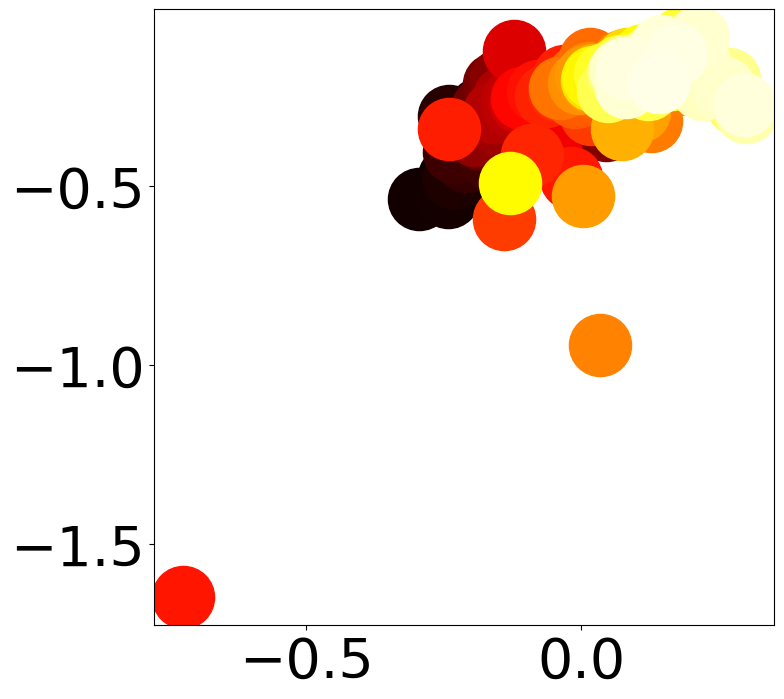

In [38]:
epoch = 7999
pth_het = f"/home/eloy/Documents/stage_reconstruction_spfluo/results_deep_learning/centriole/results_week_19_february/multi_channel_variable_lenght_stop_channel_2_/test_multi_dim_het_unknown_rot_unknown_trans/ep_{epoch}/est_heterogeneities.csv"
est_het = read_csv(pth_het)
scatter_het(est_het, fig_size=(8,8))#, perm=perm)

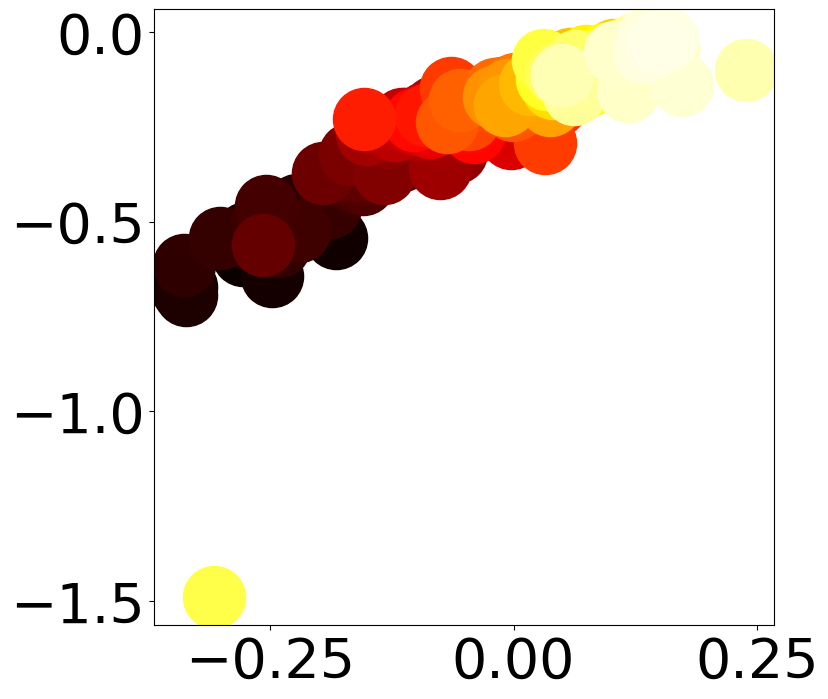

In [37]:
epoch = 9999
pth_het = f"/home/eloy/Documents/stage_reconstruction_spfluo/results_deep_learning/centriole/results_week_19_february/multi_channel_variable_lenght_stop_channel_2_/test_multi_dim_het_unknown_rot_unknown_trans/ep_{epoch}/est_heterogeneities.csv"
est_het = read_csv(pth_het)
scatter_het(est_het, fig_size=(8,8))#, perm=perm)